In [0]:
import os
from google.colab import drive
drive_root = '/content/drive'
if not os.path.exists('/content/drive'):
  drive.mount(drive_root, force_remount=True)

In [0]:
root = '/content/drive/My Drive/bin-movie'

In [0]:
from pathlib import Path
import tensorflow as tf
import numpy as np

In [0]:
print(tf.__version__)

2.2.0


In [0]:
IMG_HEIGHT, IMG_WIDTH = 224, 400


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_png(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    # return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.resize(img, [225, 400])
    img = img[:-1,:,:]
    return img


def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    label_path = tf.strings.regex_replace(file_path, 'imgs', 'bin_imgs')
    label = tf.io.read_file(label_path)
    label = decode_img(label)
    label = tf.cast(label > 0.5, tf.float32)[:, :, :1]
    return img, label

In [0]:
!du -sh '{root}/imgs.zip'
!du -sh '{root}/bin_imgs.zip'

171M	/content/drive/My Drive/bin-movie/imgs.zip
13M	/content/drive/My Drive/bin-movie/bin_imgs.zip


In [0]:
!rm -rf imgs
!rm -rf bin_imgs
!rsync --info=progress2 -r '{root}/imgs.zip' .
!rsync --info=progress2 -r '{root}/bin_imgs.zip' .

    178,422,834 100%  185.52MB/s    0:00:00 (xfr#1, to-chk=0/1)
     13,467,386 100%  180.45MB/s    0:00:00 (xfr#1, to-chk=0/1)


In [0]:
!unzip -q imgs.zip
!unzip -q bin_imgs.zip

In [0]:
!ls|head -n 20

bin_imgs
bin_imgs.zip
drive
imgs
imgs.zip
sample_data


In [0]:
!du -sh imgs
!ls imgs | wc -l
!du -sh bin_imgs
!ls bin_imgs | wc -l

174M	imgs
1523
19M	bin_imgs
1523


In [0]:
data_dir = Path(f'imgs')
input_ds = tf.data.Dataset.list_files(str(data_dir / '*.png'))
input_ds = input_ds.map(process_path)

In [0]:
for image, label in input_ds.take(10):
    print(np.sum(label) / (IMG_HEIGHT * IMG_WIDTH))

0.8754910714285714
0.7981696428571429
0.9573772321428572
0.9147098214285714
0.830390625
0.7706808035714285
0.9685714285714285
0.9263058035714286
0.8680915178571429
0.9024107142857143


In [0]:
print(image.shape, label.shape)

(224, 400, 3) (224, 400, 1)


In [0]:
train_ds = input_ds.shuffle(buffer_size=100).repeat().batch(32)

In [0]:
# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     # tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(1, 1, padding='same'),
# ])

# model = tf.keras.Sequential([
#     tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
#     tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
#     tf.keras.layers.Conv2D(1, 1, padding='same'),
# ])

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(1, 1, padding='same'),
])

In [0]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 224, 400, 8)       224       
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 224, 400, 8)       584       
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 224, 400, 1)       9         
Total params: 817
Trainable params: 817
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    # loss=tf.keras.losses.BinaryCrossentropy(),
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=tf.keras.optimizers.Adam(5e-5),
    metrics=['acc']
)

In [0]:
model.fit(train_ds, steps_per_epoch=50, epochs=50)

Epoch 1/50
50/50 [==============================] - 10s 196ms/step - loss: 0.6483 - acc: 0.1625
Epoch 2/50
50/50 [==============================] - 10s 196ms/step - loss: 0.4639 - acc: 0.3522
Epoch 3/50
50/50 [==============================] - 10s 195ms/step - loss: 0.4121 - acc: 0.4099
Epoch 4/50
50/50 [==============================] - 10s 195ms/step - loss: 0.3973 - acc: 0.4289
Epoch 5/50
50/50 [==============================] - 10s 195ms/step - loss: 0.3849 - acc: 0.4328
Epoch 6/50
50/50 [==============================] - 10s 194ms/step - loss: 0.3660 - acc: 0.4464
Epoch 7/50
50/50 [==============================] - 10s 195ms/step - loss: 0.3430 - acc: 0.4524
Epoch 8/50
50/50 [==============================] - 10s 195ms/step - loss: 0.3342 - acc: 0.4471
Epoch 9/50
50/50 [==============================] - 10s 194ms/step - loss: 0.3159 - acc: 0.4573
Epoch 10/50
50/50 [==============================] - 10s 195ms/step - loss: 0.2973 - acc: 0.4792
Epoch 11/50
50/50 [====================

In [0]:
pred = model.predict(tf.expand_dims(image, 0))

In [0]:
pred.shape

(1, 224, 400, 1)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

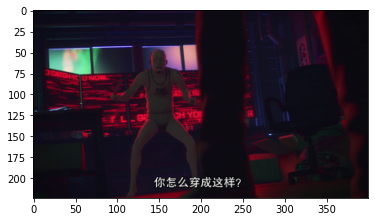

In [0]:
plt.imshow(image.numpy())

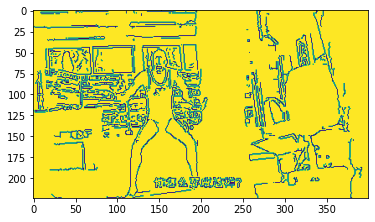

In [0]:
plt.imshow(label.numpy()[:,:,0])

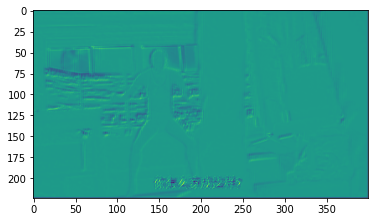

In [0]:
plt.imshow(pred[0,:,:,0])

In [0]:
model.save(f'{root}/model_export')

INFO:tensorflow:Assets written to: /content/drive/My Drive/bin-movie/model_export/assets


In [0]:
!(cd '{root}/model_export' && zip -r ../model.zip .)

updating: variables/ (stored 0%)
updating: variables/variables.data-00000-of-00002 (deflated 78%)
updating: variables/variables.data-00001-of-00002 (deflated 4%)
updating: variables/variables.index (deflated 65%)
updating: assets/ (stored 0%)
updating: saved_model.pb (deflated 88%)


In [0]:
!du -sh '{root}/model.zip'

23K	/content/drive/My Drive/bin-movie/model.zip
